In [2]:
!pip install mido
!pip install pygame
!pip install music21
!pip install scikit-learn==1.3.0

In [3]:
# import some useful libraries
import glob, nltk, joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import metrics

from PIL import Image
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer

from music21 import midi
from plugins.midi2img import midi2img
from plugins.img2midi import img2midi
from IPython.display import clear_output

In [4]:
# check to see if tensorflow mount to GPU properly
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load In museGAN dataset for visualization purposes
It turned out that the people at museGAN is leveraging midi -> image conversion. The image consisted of bar of a multi track piano roll. From the below image, the horizontal represent time and the vericle represent the instrument used. In this dataset the instrument are layered from bottom to top as piano, strings, guitar, drums, bass.


In [5]:
DATA_PATH = "../data/dataset/"

In [6]:
# download the punkt tokenizer from nltk to tokenize the piece caption
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ktrin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# load the training data
# read in the training data
caption_set = joblib.load(f'{DATA_PATH}/training_set.joblib')

# conver tuple to DF
caption_set = pd.DataFrame(caption_set, columns=['id', 'image', 'caption_list'])
caption_set.head()

,id,image,caption_list
0,commu00001,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","a, minor, mid, main, melody, cinematic, string..."
1,commu00002,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, low, accompaniment, newage, aco..."
2,commu00003,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","a, minor, mid, high, riff, cinematic, string, ..."
3,commu00004,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, pad, cinematic, choir"
4,commu00005,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","a, minor, mid, low, pad, cinematic, acoustic, ..."


In [8]:
# load the training data
# read in the training data
description_set = joblib.load(f'{DATA_PATH}/training_set_desc.joblib')

# conver tuple to DF
description_set = pd.DataFrame(description_set, columns=['id', 'image', 'desc_list'])
description_set.head()

,id,image,desc_list
0,commu00343,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",whispers of lucid skies traversing ethereal re...
1,commu07280,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",an enchanting symphony of soaring dreams where...
2,commu02735,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",uncharted melody a harmonious journey through ...
3,commu06179,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",whispers of shadows a melodys dance in the twi...
4,commu03042,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",whispers of shadows a haunting symphony where ...


In [9]:
# merge caption and description
training_set = pd.merge(caption_set, description_set, on='id')

# drop the extra image column and rename it
training_set = training_set.drop(columns=['image_y'])
training_set = training_set.rename(columns={'image_x': 'image'})
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 178
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            179 non-null    object
 1   image         179 non-null    object
 2   caption_list  179 non-null    object
 3   desc_list     179 non-null    object
dtypes: object(4)
memory usage: 7.0+ KB


# Construction of museGAN
## External Data Source
For whatever reason, if we wanted to perform GAN modeling, we can leverage conversion of MIDI data to that of the piano roll. Download the data from piano repo in README and start performing the things below. [Convert-MIDI-TO-NP-ARRAY](https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c)

# Caption Processing

In [10]:
EMBED_DIM = 100 

In [11]:
# create a tokenizer function
def tokenize_caption(text, max_seq_length=20):
    """
        Function to tokenize a string of caption
        Inputs:
            text (np.array()): an array with string of caption
            max_seq_length: maximum length of the sequence
        Outputs:
            input_captions (np.array()): an array with tokenized caption
            vocab (np.array()): an array with the vocabulary
            MAX_VOCAB_SIZE (int): maximum size of the vocabulary in the set
            MAX_SEQ_LENGTH (int): maximum length of the sequence
            
    """
    
    MAX_SEQ_LENGTH = max_seq_length # 18 + start, end
    MAX_VOCAB_SIZE = 20000


    # build a vocabulary using sklearn count vectorizer to create a vocab from the most frequent words
    input_captions = []
    max_caption_length = -1 

    for caption in tqdm(text):
        tokenized_caption = nltk.word_tokenize(caption, language='english')

        if len(tokenized_caption) > max_caption_length:
            max_caption_length = len(tokenized_caption)

        caption = (' '.join(tokenized_caption)).lower()
        input_captions.append(caption)


    vectorizer = CountVectorizer(max_features=MAX_VOCAB_SIZE)
    vectorizer.fit(input_captions)
    vocab = vectorizer.get_feature_names_out()
    MAX_VOCAB_SIZE = len(vocab)
    
    return input_captions, vocab, MAX_VOCAB_SIZE, MAX_SEQ_LENGTH


def generate_vocab_dictionary(vocab, MAX_VOCAB_SIZE):
    """
        Function to generate a dictionary of words and token id
        Inputs:
            vocab (np.array()): an array with the vocabulary
            MAX_VOCAB_SIZE (int): maximum size of the vocabulary in the set
        Outputs:
            id_vocab_dict (dict): a dictionary with token id and words
            vocab_id_dict (dict): a dictionary with words and token id
    """

    # turn vocab into a dictionary of words and token id
    # replace some words with special tokens like start/end/unk
    # if the caption is too short, pad it with <pad> token
    id_vocab_dict = {}
    vocab_id_dict = {}

    for sid, svocab in enumerate(vocab):
        id_vocab_dict[sid] = svocab
        vocab_id_dict[svocab] = sid

    id_vocab_dict[MAX_VOCAB_SIZE] = "<unk>"
    id_vocab_dict[MAX_VOCAB_SIZE + 1] = "<start>"
    id_vocab_dict[MAX_VOCAB_SIZE + 2] = "<end>"
    id_vocab_dict[MAX_VOCAB_SIZE + 3] = "<pad>"

    vocab_id_dict["<unk>"] = MAX_VOCAB_SIZE
    vocab_id_dict["<start>"] = MAX_VOCAB_SIZE + 1
    vocab_id_dict["<end>"] = MAX_VOCAB_SIZE + 2
    vocab_id_dict["<pad>"] = MAX_VOCAB_SIZE + 3

    return id_vocab_dict, vocab_id_dict

In [12]:
# tokenization - take the input caption and tokenize it
# declare a max sequence length 
def convert_text_to_data(texts, 
                         vocab_id_dict, 
                         max_length=20, 
                         type=None):
    """
        Function to convert text based data into tokenized data with proper padding
    """

    processed_data = []
    for text_num, text in enumerate(texts):
        sentence_ids = []

        # split the sentence into token
        # use the vocab to turn the word token into number
        for token in text.split():
            if token in vocab_id_dict.keys():
                sentence_ids.append(vocab_id_dict[token])
            else:
                sentence_ids.append(vocab_id_dict["<unk>"])

        vocab_size = len(vocab_id_dict.keys())

        # for decoder cases:
        # input sentence: <start>, [tokenize words from vocab], <end>, padded with <unk>
        # ouput sentence has: [tokenize words from vocab], <end>, padded with <unk>
        if type == 'input_target':
            ids = ([vocab_size - 3] + sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]
        elif type == 'output_target':
            ids = (sentence_ids + [vocab_size - 2] + [vocab_size - 1] * max_length)[:max_length]
        processed_data.append(ids)

    return np.array(processed_data)

In [13]:
# get the tokenizer
input_captions, caption_vocab, CAPTION_MAX_VOCAB_SIZE, CAPTION_MAX_SEQ_LENGTH = tokenize_caption(training_set['caption_list'].values, max_seq_length=10)
input_desc, desc_vocab, DESC_MAX_VOCAB_SIZE, DESC_MAX_SEQ_LENGTH= tokenize_caption(training_set['desc_list'].values, max_seq_length=20)

# generate the vocab dictionary
caption_id_vocab_dict, caption_vocab_id_dict = generate_vocab_dictionary(caption_vocab, CAPTION_MAX_VOCAB_SIZE)
desc_id_vocab_dict, desc_vocab_id_dict = generate_vocab_dictionary(desc_vocab, DESC_MAX_VOCAB_SIZE)

# convert the caption and description into tokenized data
caption_input_data = convert_text_to_data(input_captions,
                                            caption_vocab_id_dict,
                                            type='input_target',
                                            max_length=CAPTION_MAX_SEQ_LENGTH)


# convert the caption and description into tokenized data
desc_input_data = convert_text_to_data(input_desc,
                                        desc_vocab_id_dict,
                                        type='input_target',
                                        max_length=DESC_MAX_SEQ_LENGTH)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

In [14]:
# added the tokenized caption to the metadata
training_set['tokenized_captions'] = caption_input_data.tolist()
training_set['tokenized_desc'] = desc_input_data.tolist()
training_set

,id,image,caption_list,desc_list,tokenized_captions,tokenized_desc
0,commu00006,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","a, minor, mid, high, riff, cinematic, string, ...",echoes of twilight sway a kaleidoscope of emot...,"[35, 34, 34, 21, 34, 20, 34, 14, 34, 27]","[1054, 264, 630, 934, 860, 1053, 481, 630, 292..."
1,commu00041,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, high, main, melody, newage, aco...",rhapsody of brilliance a mosaic of emotions un...,"[35, 34, 34, 18, 34, 20, 34, 14, 34, 17]","[1054, 724, 630, 135, 1053, 597, 630, 292, 973..."
2,commu00145,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","a, minor, mid, high, riff, cinematic, string, ...",silent whispers of twilight a souls melancholi...,"[35, 34, 34, 21, 34, 20, 34, 14, 34, 27]","[1054, 770, 1031, 630, 934, 1053, 799, 553, 47..."
3,commu00146,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, low, riff, cinematic, acoustic,...",echoes of a forgotten estate harmonize in a hi...,"[35, 34, 34, 18, 34, 20, 34, 16, 34, 27]","[1054, 264, 630, 1053, 366, 324, 411, 452, 105..."
4,commu00234,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, high, main, melody, newage, aco...",melodies in celestial harmony a wandering soul...,"[35, 34, 34, 18, 34, 20, 34, 14, 34, 17]","[1054, 558, 452, 168, 414, 1053, 1006, 799, 47..."
...,...,...,...,...,...,...
174,commu10212,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, pad, cinematic, string, ensemble",melodic whispers unseen harmony of the iii cra...,"[35, 34, 34, 18, 34, 20, 34, 24, 34, 6]","[1054, 557, 1031, 967, 414, 630, 890, 447, 197..."
175,commu10223,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, accompaniment, cinematic, strin...",uncharted whispers a mysterious melody echoes ...,"[35, 34, 34, 18, 34, 20, 34, 0, 34, 6]","[1054, 936, 1031, 1053, 605, 559, 264, 898, 90..."
176,commu10250,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","a, minor, mid, riff, cinematic, electric, guit...",lost in the shadows where melodies disguise th...,"[35, 34, 34, 21, 34, 20, 34, 27, 34, 6]","[1054, 523, 452, 890, 765, 1022, 558, 236, 890..."
177,commu10278,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","c, major, mid, accompaniment, cinematic, strin...",whispers of time a melodic voyage through ethe...,"[35, 34, 34, 18, 34, 20, 34, 0, 34, 6]","[1054, 1031, 630, 902, 1053, 557, 1001, 898, 3..."


In [15]:
# create image, tokenized pair
# create image-caption pairs
datasets = []
for i, row in training_set.iterrows():
    caption = np.array(row['tokenized_captions'])
    desc = np.array(row['tokenized_desc'])
    images = np.array(row['image'])
    try:
        datasets.append((images, desc, caption))
    except:
        pass
datasets[:3]

[(array([[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
  
         ...,
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
  
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]], dtype=float32),
  array([1054,  264,  630,  934,  860, 1053,  481,  630,  292,  945,   55,
         1053,  745,  630,  765,  261,  416,  621,  961, 1053]),
  array([35, 34, 34, 21, 34, 20, 34, 14, 34, 27])),
 (array([[[0.],
          [0.],
          [0.],
          ...,
          [0.],
        

# GAN Definition

GAN model consists of two part:
1. Generator
2. Discriminator

In [21]:
def caption_enhanced_generator(latent_dim=100, 
                               caption_dim=DESC_MAX_SEQ_LENGTH, 
                               vocab_size=len(desc_vocab_id_dict.keys()), 
                               embed_dim=EMBED_DIM):
    """Define the generator model
        Inputs:
            latent_dim: dimension of the latent space
        Output:
            model: the generator model
    """
    n_nodes = 128 * 53 * 53

    # vectorized input layers
    input_layer = keras.layers.Input(shape=(latent_dim,), name='input_layer')
    
    # # vectorized caption input layers
    # # apply word embedding to the caption
    caption_input_layer = keras.layers.Input(shape=(caption_dim,), name='caption_input_layer')
    embedding_layer  = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                name='caption_embedding_layer')
    embed_caption = embedding_layer(caption_input_layer)

    # pool the caption layer
    global_average_pooling1d_embed = keras.layers.GlobalAveragePooling1D()(embed_caption)

    # concat the input layer and the caption layer
    concat_layer = keras.layers.Concatenate(axis=1)([input_layer, global_average_pooling1d_embed])

    # apply 1D Global Average Pooling to the output of the dense layer on the caption decoded
    # global_average_pooling1d_layer = keras.layers.GlobalAveragePooling1D()(decoder_output)

    # Dense Layer 1
    dense1 = keras.layers.Dense(n_nodes)(concat_layer)
    leaky_relu1 = keras.layers.LeakyReLU(alpha=0.35)(dense1)
    reshape_layer = keras.layers.Reshape((53, 53, 128))(leaky_relu1)

    # Dense Layer 2
    dense2 =  keras.layers.Dense(1024)(reshape_layer)

    # Conv2DTranspose Layer
    conv2d_transpose = keras.layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same')(dense2)

    # Dense Layer 3
    dense3 =  keras.layers.Dense(1024)(conv2d_transpose)
    leaky_relu2 = keras.layers.LeakyReLU(alpha=0.35)(dense3)

    # Dense Layer 4
    dense4 =  keras.layers.Dense(512)(leaky_relu2)

    # Conv2D Layer
    conv2d = keras.layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(dense4)

    # Create the model
    model = keras.Model(inputs=[input_layer,caption_input_layer], outputs=conv2d, name='generator')
    return model

In [22]:
def caption_enhanced_discriminator(in_shape = (106,106,1), 
                                   caption_dim=CAPTION_MAX_SEQ_LENGTH, 
                                   vocab_size=len(caption_vocab_id_dict.keys()), 
                                   embed_dim=EMBED_DIM):
    """
        GAN discriminator model
        Inputs:
            in_shape: shape of the input image
        Output:
            model: discriminator model with binary crossentropy loss to denotes if the image is real or fake
    """
    # Input Layer
    input_layer = keras.layers.Input(shape=in_shape, name='input_layer')
    
    # 2D Convlution Layer 1
    conv1 = keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same')(input_layer)
    leaky_relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(0.5)(leaky_relu1)

    # 2D Convlution Layer 2
    conv2 = keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same')(dropout1)
    leaky_relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(0.5)(leaky_relu2)

    # Flatten Layer
    flatten_layer = keras.layers.Flatten()(dropout2)

    # Batch Normalization Layer
    batch_normalization = keras.layers.BatchNormalization()(flatten_layer)


    # Reduced Dense Layer
    reduced_dense = keras.layers.Dense(100)(batch_normalization)

    ## vectorized caption input layers
    # # apply word embedding to the caption
    caption_input_layer = keras.layers.Input(shape=(caption_dim,), name='caption_input_layer')
    embedding_layer  = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                name='caption_embedding_layer')
    embed_caption = embedding_layer(caption_input_layer)

    # pool the caption layer
    global_average_pooling1d_embed = keras.layers.GlobalAveragePooling1D()(embed_caption)

    # concat the input layer and the caption layer
    concat_layer = keras.layers.Concatenate(axis=1)([reduced_dense, global_average_pooling1d_embed])

    dense_layer = keras.layers.Dense(1024)(concat_layer)

    # Dense Output Disminator Layer
    discriminate_layer = keras.layers.Dense(1, activation='sigmoid')(dense_layer)
    
    # Create the model
    model = keras.Model(inputs=[input_layer, caption_input_layer], outputs=discriminate_layer, name='discriminator_model')
    
    # model compile
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, clipnorm=3) #3
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [23]:
def caption_enhanced_miniGAN(g_model, d_model,
                             g_model_input_shape=100, 
                             g_model_desc_input_shape=DESC_MAX_SEQ_LENGTH,
                             d_model_caption_input_shape=CAPTION_MAX_SEQ_LENGTH):
    """
        GAN model architecture
        Inputs:
            g_model: generator model
            d_model: discriminator model
            g_model_input_shape: shape of the input to the generator model
            g_model_caption_input_shape: shape of the input caption to the generator model
        Output:
            model: GAN model
    """
    # Pause the training of the discriminator
    d_model.trainable = False

    # Define the input layer for the generator
    generator_input = keras.layers.Input(shape=(g_model_input_shape), name='generator_input')  # Specify the shape of the generator's input
    desc_input = keras.layers.Input(shape=(g_model_desc_input_shape), name='generator_description')  # Specify the shape of the generator's input
    caption_input = keras.layers.Input(shape=(d_model_caption_input_shape), name='discriminator_caption')  # Specify the shape of the generator's input

    # Define the output of the generator
    generator_output = g_model([generator_input, desc_input])

    # Define the output of the discriminator
    discriminator_output = d_model([generator_output, caption_input])

    # Create the model
    model = keras.Model(inputs=[generator_input, desc_input, caption_input], outputs=discriminator_output)

    # Compile the model
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5, beta_2=0.9, clipnorm=2)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [24]:
latent_dim = 100
g_model = caption_enhanced_generator(latent_dim)
d_model = caption_enhanced_discriminator()
gan_model = caption_enhanced_miniGAN(g_model, d_model)
g_model.summary(), d_model.summary(), gan_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input_layer (InputLayer [(None, 20)]         0                                            
__________________________________________________________________________________________________
caption_embedding_layer (Embedd (None, 20, 100)      105700      caption_input_layer[0][0]        
__________________________________________________________________________________________________
input_layer (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 100)          0           caption_embedding_layer[0][0]    
__________________________________________________________________________________________

(None, None, None)

In [25]:
# # plot the generated model
# keras.utils.plot_model(g_model, show_shapes=True, dpi=90)

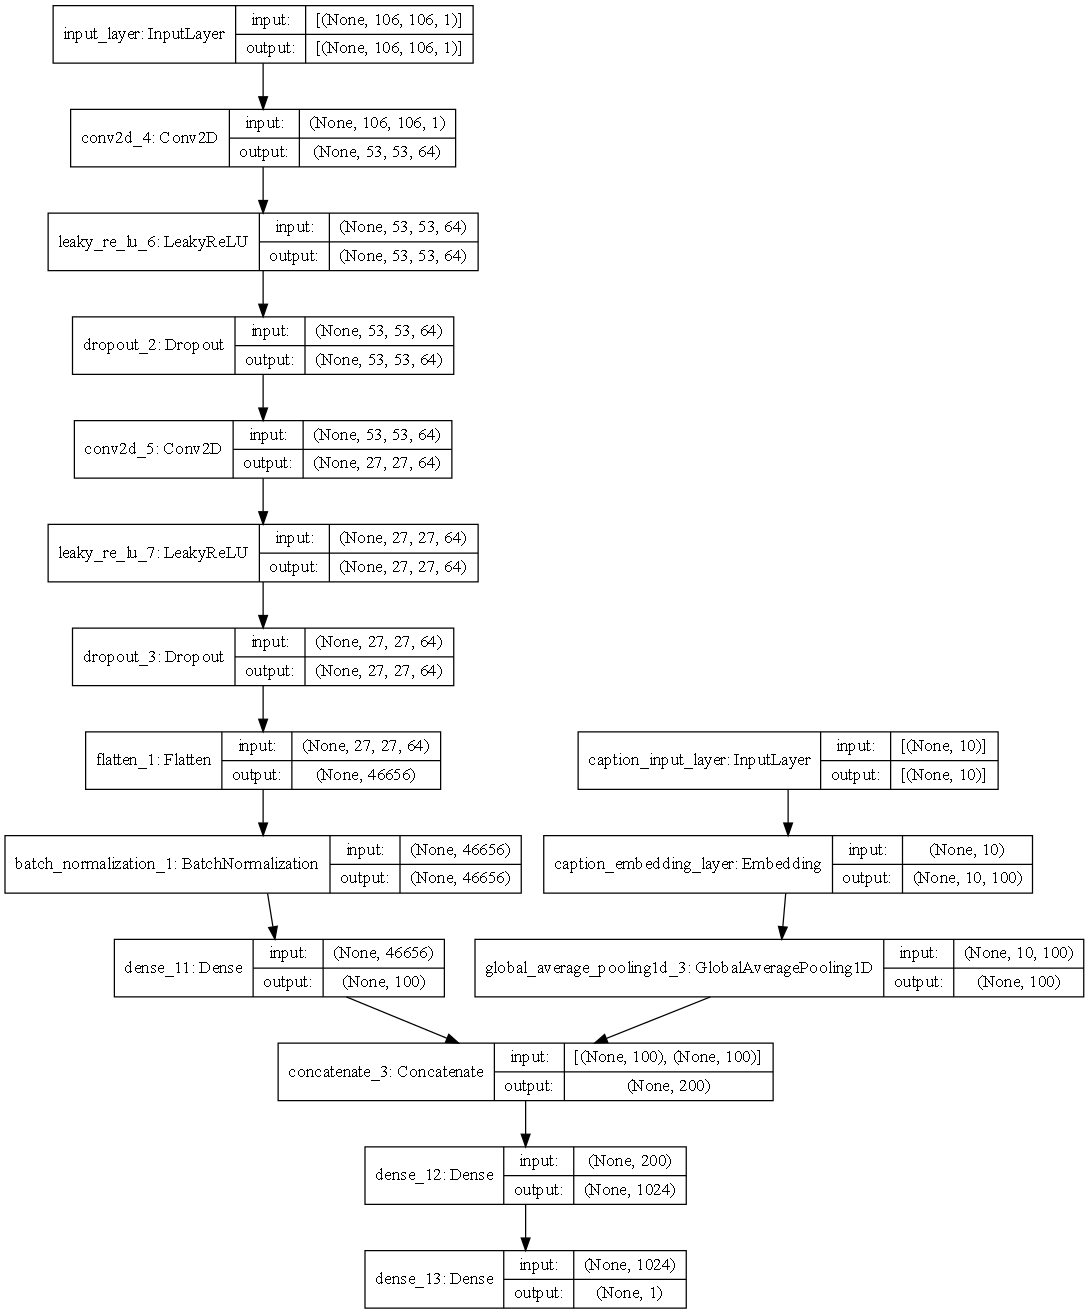

In [26]:
# # plot the generated model
# keras.utils.plot_model(d_model, show_shapes=True, dpi=90)

In [27]:
# # plot the generated model
# keras.utils.plot_model(gan_model, show_shapes=True, dpi=90)

In [28]:
def generate_real_samples(dataset, n_samples):
    # slice the image and caption from the dataset
    # generate 'real' class labels (1)
    images, desc, captions = zip(*dataset)
    images = np.array(images)
    desc = np.array(desc)
    captions = np.array(captions)

    ix = np.random.randint(0, images.shape[0], n_samples)

    X_img = images[ix]
    X_desc = desc[ix]   
    X_cap = captions[ix]
    
    y = np.ones((n_samples, 1))
    return X_img, X_desc, X_cap, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


def generate_fake_samples(g_model, latent_dim, caption, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict([x_input, caption])
    y = np.zeros((n_samples, 1))
    return X, y

In [29]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=16):
    bat_per_epo = int(len(dataset) / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            # prepare a mini batch of real and fake sample
            X_img_real, x_desc_real, x_cap_real, y_real = generate_real_samples(dataset, half_batch)
            X_img_fake, y_fake = generate_fake_samples(g_model, latent_dim, x_desc_real, half_batch)

            print(np.unique(X_img_real), np.unique(X_img_fake))
            # print(X_img_real, X_img_fake)
            
            # use real caption input to generate a fake image
            # train the discriminator on fake images generate from real caption and a set of latent points
            X, y = np.vstack((X_img_real, X_img_fake)), np.vstack((y_real, y_fake))
            X_cap = np.vstack((x_cap_real, x_cap_real))
            d_loss, _ = d_model.train_on_batch([X, X_cap], y)


            # print("Discriminator Loss: ", (d_loss, _))
            # prepare points in latent space and fetch some real caption input
            X_img_real_full, x_desc_real_full, x_cap_real_full, y_real_full = generate_real_samples(dataset, n_batch)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))

            # perform full batch training on e2e GAN model 
            # using the latent point and real caption as input
            g_loss = gan_model.train_on_batch([X_gan, x_desc_real_full, x_cap_real_full], y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # test print the image
            # X = g_model.predict([X_gan, x_cap_real_full])
            # print(np.unique(X))

        if (i+1) % 2 == 0:
            # summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()


In [30]:
len(datasets)

179

In [31]:
# read in the training data
import random
random.seed(544)

# training_dataset = random.sample(datasets, 4096) #5 is the lenth of the sample
training_dataset = datasets

In [32]:
train(g_model, d_model, gan_model, training_dataset, latent_dim, n_epochs=5, n_batch=6)

[0. 1.] [0.0000000e+00 1.1918995e-38 1.1938836e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 1/29, d=0.046, g=0.134
[0. 1.] [0.0000000e+00 1.2165395e-38 1.2375275e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 2/29, d=0.000, g=0.122
[0. 1.] [0.0000000e+00 1.1958072e-38 1.2144807e-38 ... 9.9999964e-01 9.9999988e-01
 1.0000000e+00]
>5, 3/29, d=0.030, g=0.131
[0. 1.] [0.0000000e+00 1.1804607e-38 1.2002491e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 4/29, d=0.009, g=0.134
[0. 1.] [0.0000000e+00 1.1952325e-38 1.1991966e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 5/29, d=0.000, g=0.207
[0. 1.] [0.0000000e+00 1.2462823e-38 1.2565747e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 6/29, d=0.000, g=0.175
[0. 1.] [0.0000000e+00 1.1831114e-38 1.1909270e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 7/29, d=0.043, g=0.151
[0. 1.] [0.0000000e+00 1.2029353e-38 1.2303070e-38 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
>5, 8/29, d=0.238, 

In [33]:
# save the model
g_model.save('../models/mini-gan/double_cap_comMU_generator_model_desc_g5.h5')
d_model.save('../models/mini-gan/double_cap_comMU_discriminator_model_desc_g5.h5')
gan_model.save('../models/mini-gan/double_cap_comMU_gan_model_desc_g5.h5')

In [34]:
# Load model
g_model = keras.models.load_model('../models/mini-gan/double_cap_comMU_generator_model_desc_g5.h5')

In [35]:
# select a random row from the metadata to get the caption
row = training_set.sample(1, random_state=86)

# get the description
NLP_desc = row['desc_list'].values
desc = [np.array(a) for a in row['tokenized_desc'].values]
desc = np.array(desc)   

# get a random image tokenize caption and actual caption
NLP_caption = row['caption_list'].values
caption = [np.array(a) for a in row['tokenized_captions'].values]
caption = np.array(caption)
NLP_caption, desc, caption

(array(['a, minor, mid, high, main, melody, cinematic, string, ensemble'],
       dtype=object),
 array([[1054,  957,  765,  328,  264,  206,  463, 1035,  890,  616, 1030,
          881,  630,  520,   59,  554,  992,  993,  893,  455]]),
 array([[35, 34, 34, 21, 34, 20, 34, 14, 34, 17]]))

In [36]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# declare a latent space
latent_dim = 100
latent_points = generate_latent_points(latent_dim, 1)
latent_points.shape, caption.shape

((1, 100), (1, 10))

In [50]:
model = g_model
X = np.ceil(np.round(g_model.predict([latent_points, desc])*100,1))
array = np.array(X.reshape(106,106),dtype = np.uint8)
np.unique(array)

array([0, 1], dtype=uint8)

In [51]:
array*=255
new_image = Image.fromarray(array,'L')
new_image = new_image.save(f'{DATA_PATH}/images/captioned_piece_test_desc.png')

In [32]:
# reconvert MIDI images to MIDI files
image_path = f'{DATA_PATH}/images/captioned_piece_test_desc.png'
output_path = f'{DATA_PATH}/images/desc'

img2midi_obj = img2midi(image_path, output_path, resolution=0.25)
img2midi_obj.convert_to_midi(name='double_captioned_piece_test_desc')

In [33]:
# run to cell to play
# stop the cell and run sp.stop to stop the music
from music21 import midi, converter, instrument, note, chord

mf = midi.MidiFile()
mf.open(f"{output_path}/music.mid")
mf.read()
mf.close()
s = midi.translate.midiFileToStream(mf)
sp = midi.realtime.StreamPlayer(s)
sp.play()

pygame 2.5.1 (SDL 2.28.2, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
sp.stop